# 앙상블

앙상블이 정확히 뭔데?
- 앙상블은 한마디로 '일련의 예측기'
- 앙상블을 만드는 것(=예측기 여러 개를 만드는 것)은 앙상블 학습
- 앙상블 학습 알고리즘을 앙상블 방법이라고 한다

여러 개를 왜 만드는데?
- 다수결 방식의 일종이라고 생각하면 좋음

# 투표 기반 분류

아이디어: 각 분류기의 예측을 취합해 가장 많이 선택된 클래스로 예측해보자 >>> 다수결 방식<br>
<br>
??? 아무리 분류기가 많아도 정확도가 떨어지면 별로이지 않은가?
- 랜덤 추측보다 조금 나은 학습기(==약한 학습기)도 많이 모이면 강한 앙상블 학습기가 될 수 있다
- 이는 큰 수의 법칙 때문이다<br>
ex. 정확도가 60%인 분류기 1000개를 만들었을 경우 이들을 취합하는 앙상블은 99%의 정확도를 보인다

주의
- 조건1. 모든 분류기가 완벽하게 독립적이어야 한다. 즉
    - 알고리즘이 서로 비슷하면 안되고 (하나는 트리, 다른 건 랜덤 포레스트와 같은 경우)
    - 훈련에 쓰는 샘플이 서로 겹치지 않고 다 달라야 한다
- 조건 2. 오차에 상관관계가 없어야 한다. 즉 오차의 종류, 나온 이유들이 달라야 한다<br>
예를 들면 하나는 힌지 손실(선형SVC), 하나는 불순도(트리) ... 와 같아야 한다

<br>
상기 사항이 중요한 이유: 같은 데이터로 훈련하고 같은 모델을 쓴다면 서로 비슷한 오차를 낼 것이고, 이러면 잘못된 클래스가 다수인 경우도 많아져 앙상블의 정확도가 낮아지기 때문이다 <br>

방법: 각기 다른 알고리즘으로 학습시키면 된다!!!

In [1]:
import scipy

1-scipy.stats.binom.cdf(499, 1000, 0.6)

0.9999999999329903

In [2]:
"""
투표 기반 분류기 예시
    사용 모델
        1. 로지스틱
        2. 랜덤 포레스트: 트리
        3. SVC
        
    조건을 만족하는가?
        1: 서로 겹치는 알고리즘이 없다
"""

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X, y = make_moons(n_samples=10000, noise=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression()
rnd_clf=  RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard"
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score


for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.897
RandomForestClassifier 0.992
SVC 0.993
VotingClassifier 0.9915


간접 투표: 클래스의 확률 예측 >>> voting=soft로 설정 + 분류기가 predict_proba를 제공할 것
직접 투표: 클래스 레이블 예측 >>> voting=hard(default)

# 배깅, 페이스팅

서브셋을 무작위로 구성해서 한 알고리즘을 여러번 쓰는 것. <br>
즉 ( 무작위 훈런셋 + 같은 훈련방식 ) <br>
여기서 훈련셋을 만들 때<br>
- 중복을 허용하면서 리샘플링 시(==부트스트래핑) 배깅 (Bootstrap AGGrigating)
- 중복 없이 리샘플링하면 페이스팅 <br>
(단, 페이스팅의 경우 태생적 한계(중복 불가)로 인해 훈련셋 구성에 제한이 있다)
<br>

상세 과정
1. 훈련셋의 서브셋 구성
2. 서브셋으로 훈련 개시
3. 1, 2를 지정한 횟수만큼 반복. 즉 무작위 훈련셋을 ~번 만들어 ~개의 모델을 훈련한다
    - 이 과정은 병렬로도 가능하다. 굳이 한명이 ~쪼개고 ~훈련하고 또 쪼개고 훈련하고를 왔다갔다할 필요가 없다
4. 이렇게 만든 앙상블은 모든 예측기의 예측을 모아 새로은 샘플을 예측한다. <br>
이 때 수집함수는 분류일 땐 최빈값, 회귀일 땐 평균을 계산한다.

결과
- 개별 예측기는 원본 전체로 훈련했을 때와 비교했을 때 편향이 크다. 즉 과소적합된다
- 하지만 수집 함수를 거치면 편향과 분산이 감소한다.<br>
(정확히 말하면 편향은 비슷하지만 분산은 줄어든다)

In [4]:
"""
    ex. sklearn의 배깅
    
    BaggingClassifier(
        사용할 모델(model params),
        n_estimators=만들 모델 수
        n_jobs=사용할 CPU 코어 수 지정. -1은 전부 사용. 기본 1
        max_samples=서브셋 크기
        bootstrap(_features)=(특성) 부트스트래핑 여부 지정. 기본 true, if false, 중복 미허용 >>> 페이스팅
    )
    
"""

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 배깅이 페이스팅보다 편향이 조금 더 높다<br>
왜냐하면 배깅이 페이스팅보다 서브셋의 다양성이 더 높기 때문에 더 많은 데이터에 맞춰주려다 01.4.6에서와 같은 일이 발생하기 때문이다<br>
즉 대표성이 떨어지는 샘플까지 포함해 훈련할 수 있기 때문이다
- 하지만 서브셋으로 나눠 훈련하는 것은 예측기들의 상관관관계를 줄이므로 앙상블의 분산을 감소시킨다
- 보통 배깅이 더 괜찮지만 자원이 넉넉하면 교차 검증으로 더 나은 것을 선택하길 권장한다

### oob 평가

배깅을 쓴다면 선택받지 못한 훈련 샘플이 있을 수 있는데 (~ 37%) 이들을 이용해 앙상블을 평가하는 기법이다.<br>
선택받지 못한 이들을 out of bag이라고 해서 OOB 평가라고 하는 것<BR>
\>>>마치 족발 뼈에 붙은 살점 하나까지 살뜰히 먹는듯한 느낌

In [5]:
"""
oob 평가 방법
    1. BaggingClassifier의 oob_score=True로 설정한다
    2. 점수 확인은 .oob_score_로 한다
"""

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.99075

In [6]:
""" 테스트 셋을 이용했을 때와 비교 """

from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.991

In [7]:
"""
    oob 샘플에 대한 결정 함수의 결과는 
        분류 (BaggingClassifier): 객체의 oob_decision_function_ 속성
        회귀 (BaggingRegressor): 객체의 oob_prediction_ 속성
"""

bag_clf.oob_decision_function_

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [8]:
import sklearn

sklearn.__version__

'1.0.2'

In [12]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=4,
                       n_informative=2, n_targets=1,
                       random_state=0, shuffle=False)
regr = BaggingRegressor(SVR(),
                        n_estimators=10, random_state=0, oob_score=True).fit(X, y)

regr.oob_prediction_

C:\Users\rksla\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1163: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


array([  6.91364227,   2.59878294,  -2.85577067,   3.00389267,
         2.38419071,  -6.39654171,   0.04298189,  16.83802858,
       -11.51678291,   9.50958289,  -8.20613508,  -9.94285836,
       -11.29371365, -14.01008031,  -0.97204048,  -5.89536374,
        -3.86639939,  -8.3103529 ,  -2.17321665, -13.18031101,
        -1.23370914,   6.21612631,  -0.7220902 ,   5.50148044,
         9.7042946 ,  -1.87841886,   0.56750476,   4.17343993,
         0.        ,   4.05708112,  -9.49638063,  -5.97287474,
         7.98981317,  -8.93761691,   0.94726952,  -5.50335987,
         2.94877933,  -5.76602793, -14.08162952,  -5.32411099,
         4.61372766,  -1.80549947,   7.68737396,  -2.42211197,
       -13.50596945,  -8.84018935,  -9.56012094,   2.57585415,
        -9.97555014,   2.23916267,  -9.30259656, -10.21956994,
         0.43298247,  -2.48395703,  -0.56586454, -16.68130551,
       -12.4922633 ,  -6.22343742,  -7.34625086,   1.45506019,
        -8.93855906,  -6.81804087, -14.11717427,  -4.76

# 특성 샘플링: 랜덤 패치, 랜덤 서브스페이스

랜덤 패치: 훈련 특성, 훈련 샘플 모두 무작위 선택  
랜덤 서브스페이스: 훈련 특성만 무작위로 선택, 샘플은 전부 사용    
<br>
효과: 편향 증가, 분산은 감소 >>> 과소적합 정도는 커질 수 있다. (규제가 있는 회귀를 생각하면 이해가 쉬울 것)

# 랜덤 포레스트

배깅(랜덤 패치) + 트리 <br>
결정 트리의 앙상블이 랜덤 포레스트

모델 구축 시 무작위로 고른 특성 후보 중에서 최적의 특성을 찾아낸다(ex. ch.06 iris의 꽃잎 너비)  
효과: 트리 다양화, 분산 감소 (대신, 편향은 증가)

In [13]:
""" 
구현 예시
    n_estimators: 만들 트리 개수
    n_jobs: 사용할 CPU 코어 수, -1 >>> 전부 사용
    
    *** 전달 가능한 매개변수는 배깅 + 트리와 거의 같다
"""

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9875

In [14]:
y_pred_rf

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
""" 
    랜덤 포레스트를 BaggingClassifier로 만든 방식
"""

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9875

### 익스트림 랜덤 트리(엑스트라 트리)

랜덤 포레스트
- 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾아낸다<br>
- 정리하면
    1. 후보 특성 선택
    2. 그 후보 안에서 임계값을 계산해 최적으로 분할한다
        
<br>
엑스트라 트리
- 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다<br>
- 정리하면
    1. 후보 특성 선택
    2. 그 후보 안에서 임계값 계산 없이 그냥 나눈다. 그냥 아무렇게나 나눈다
    3. 나눈 결과 중 가장 예쁘게 나누어진 트리를 선택한다

즉, 엑스트라 트리는 일단은 나누고 생각하자는 방식이라고 볼 수 있다<br>
효과
- 가장 큰 효과는 훈련 시간 단축 >>> 임계값 계산 과정이 없으니까
- 무작위한 정도 증가, 분산 감소, 편향 증가 (이건 공통)

In [18]:
"""
    사용법은 랜덤 포레스트랑 똑같다
"""

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

clf.predict([[0, 0, 0, 0]])

array([1])

### 특성 중요도

랜덤 포레스트는 .feature_importances_ 특성의 상대적 중요도를 알 수 있다 (트리 기반 모델은 전부 제공)<br>
특성 중요도 계산 과정
1. 특성이 불순도를 얼마나 감소시키는지 계산한다<br>
즉 (현재 노드의 샘플 비율 \* 불순도) - (좌측 자식의 샘플 비율 \* 불순도) - (우측 자식의 샘플 비율 \* 불순도)를 계산한다
2. 각 트리 별로 1을 반복해 총합을 구한다
3. 특성의 중요도 합이 1이 되도록 총합을 정규화한다

In [22]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10956139829502637
sepal width (cm) 0.024033107251026035
petal length (cm) 0.42777908493963296
petal width (cm) 0.4386264095143147


# 부스팅

약한 학습기 여러 개를 연결하여 강한 학습기를 만들자  
직전 모델을 보완해가나는 식으로 일련의 예측기를 학습시키자  
<br>
종류: 아다부스트(Adaptive Boosting), 그래디언트 부스팅

### 아다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것  
이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다  
과정  
1. 첫 번째 모델을 만든다
2. 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다
3. 2의 가중치를 이용해 훈련하고 다시 모델을 만든다
4. 2, 3을 반복한다
  
\*** 주의: 전체 과정이 순차적이기 때문에 병렬화가 불가능하다

#### 상세 과정

1. 각 샘플 가중치 $w^\left( i \right )$는 초기에 $1 \over {m}$로 초기화된다
2. 첫 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산된다
> $r_j=\left ( 예측이 틀린 가중치 샘플의 총합 \over {전체 가중치 총합} \right )$  
3. 예측기 가중치 $\alpha_j$를 계산한다 ($\eta$: 학습률 하이퍼파라미터(기본 1))  
> $\alpha_j = \eta \log {1-r_j \over r_j}$
  
이 때
- $r_j > 0.5$ >>> $\alpha_j < 0$ 즉, 무작위 추측보다도 못함
- $r_j \simeq 0.5$ >>> $\alpha_j \simeq 0$, 무작위 추측과 비슷함
- $r_j < 0.5$ >>> $\alpha_j > 0$ 좀 더 정확함
4. 샘플의 가중치를 업데이트한다. 여기서 잘못 분류된 샘플의 가중치가 증가한다.  
$ 
각 샘플의 가중치 w^\left (i \right)=
\begin{cases}
w^\left (i \right), \mbox{ j번째 분류기로 예측한 훈련 샘플 i의 예측이 맞을 때} \\
w^\left (i \right), \exp (\alpha_j) \mbox{ j번째 분류기로 예측한 훈련 샘플 i의 예측이 틀릴 때}
\end{cases}
$
5. 모든 샘플의 가중치를 정규화한다 >>> 가중치 총합으로 나누는 방식으로
6. 새 예측기가 업데이트된 가중치를 사용해 훈련한다.
7. 최대 반복 횟수에 도달하거나 좋은 모델이 나올 때까지 2 ~ 6을 반복한다

#### 아다부스트로 구축한 모델의 예측

1. 위에서 만든 모든 예측기로 예측할 대상 $\mathbf x$에 대해 예측한다
2. 예측기마다 각자의 가중치 $\alpha_j$를 더해 예측 결과를 만든다
3. 가중치 합이 가장 큰 클래스로 분류한다
> $\hat{y}(\mathbf x) = \mbox{argmax}(k) \sum_{j=1}^{예측기 수} \alpha_j$
(즉, 클래스 별 가중치 합 중 가장 큰 값을 갖는 클래스)

사이킷런에선 SAMME 알고리즘 사용  
SAMME?  
SAMME: 아다부스트의 다중 클래스 버전 (클래스가 둘만 있으면 아다부스트와 똑같다)  
클래스 확률을 추정한다면 SAMME.R 사용 가능

In [13]:
""" 아다부스트 용례: 결정 트리로 구현할 경우 (Classifier, Regressor 모두 있다) """

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200, algorithm="SAMME.R", learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

과대 적합 시엔 추정기 수를 줄이거나, 규제를 강하게 할 것 (ex. n_estimators 감소, learning_rate 조정 ...)

### 그래디언트 부스팅

이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시키는 방식  
  
아다부스트와 공통점: 이전 모델의 오차를 이용해 다음 모델 구축 시 참고한다  
차이점  
- 아다부스트: 이전 예측기의 에러율, 가중치를 이용해 다음 예측기 개선
- 그래디언트 부스팅: 이전 예측기가 만든 잔여 오차를 이용해 다음 예측기 개선<br>
즉, 이전 예측기가 만든 잔여 오차가 다음 예측기의 input
  
잔여 오차: 기존 예측 결과 - 현재 예측 결과 (초기엔 "원본 - 예측 결과")

In [14]:
""" 구현 예시: 결정 트리 활용 """

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)

gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3)

In [15]:
""" 최적의 모델 탐색: 1. 검증 오차가 최소인 모델 찾아내기 """

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=79)

In [16]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

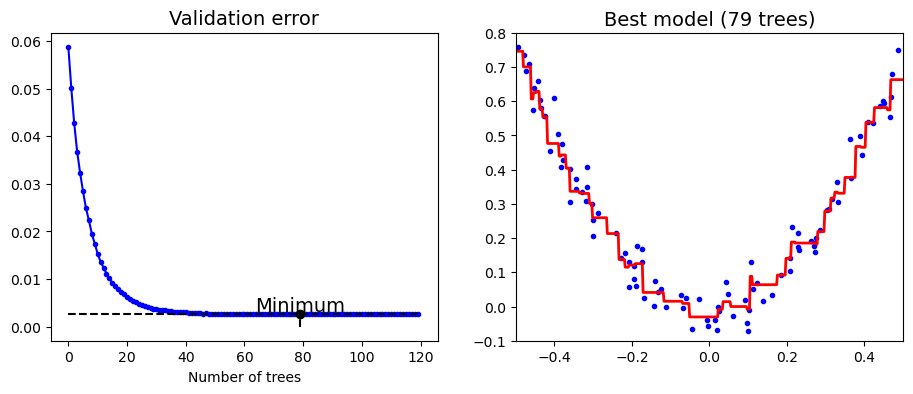

In [17]:
import matplotlib.pyplot as plt

min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)

plt.show()

In [25]:
""" 최적의 모델 탐색 2. 조기 종료 """

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = np.inf
errors_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        errors_going_up = 0
    else :
        errors_going_up += 1
        if errors_going_up == 5:
            break

In [26]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

59
Minimum validation MSE: 0.0026930464329994377


GradientBoostigRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플 비율을 지정할 수 있다  
\>>> subsample=0.25: 각 트리는 회마다 무작위로 선택된 훈련 샘플 25%만 이용해 학습  
효과: 훈련 속도 향상, 편향은 증가 / 분산은 감소

# 스태킹

아이디어: 예측을 단순 취합하지말고, 예측을 취합하는 모델을 만들자  
\>>> 예측 결과로 에측하자  
방법
1. 훈련 세트를 두 개로 쪼갠다
2. 한 세트로 학습시킨다
3. 2로 훈련한 모델로 다른 세트(홀드아웃)에 대한 예측을 만든다
4. 3의 결과를 이용해 블렌더가 예측한다  
  
특징
- 3의 예측은 예측기가 전에 보지 못한 샘플이기에 완전 새로운 예측이다
- 블렌더가 사용하는 데이터의 차원 수는 직전 레이어에서 만든 모델의 수와 같다
- 여러 모델을 여러 레이어에 조합하여 쓸 수 있다. (이 때. 훈련 세트는 레이어 수만큼 나눈다)
  
\*** 사이킷런에선 미지원